# Probabilistic Approximate Optimization Algorithm

In this example, we recreate Figure 3(c) of [https://arxiv.org/abs/2507.07420](https://arxiv.org/abs/2507.07420).

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from isax import (
    AnnealedIsingSampler,
    BlockGraph,
    Edge,
    IsingModel,
    Node,
    sample_chain,
    SamplingArgs,
)
from scipy.optimize import minimize

In [2]:
L = 6
num_sites = L * L * L
nodes = [Node() for _ in range(num_sites)]

edges, edge_weights = [], []
for x in range(L):
    for y in range(L):
        for z in range(L):
            i = x * L * L + y * L + z
            j = ((x + 1) % L) * L * L + y * L + z
            k = x * L * L + ((y + 1) % L) * L + z
            l = x * L * L + y * L + ((z + 1) % L)
            edges.append(Edge(nodes[i], nodes[j]))
            edges.append(Edge(nodes[i], nodes[k]))
            edges.append(Edge(nodes[i], nodes[l]))
            J = np.random.choice([-1, 1])
            edge_weights.extend([J, J, J])

edge_weights = jnp.array(edge_weights)
node_biases = jnp.zeros(num_sites)

even_nodes, odd_nodes = [], []
for x in range(L):
    for y in range(L):
        for z in range(L):
            (even_nodes if (x + y + z) % 2 == 0 else odd_nodes).append(
                nodes[x * L * L + y * L + z]
            )

blocks = [even_nodes, odd_nodes]

In [3]:
num_beta = 5
num_mcs = 720
num_exps = 100_00
init_betas = jnp.ones(num_beta) * 2

graph = BlockGraph(blocks, edges)
params = graph.get_sampling_params()
edge_indices, edge_mask = graph.get_edge_structure()
model = IsingModel(weights=edge_weights, biases=node_biases)

In [4]:
def _sample_energy(betas, key):
    betas = jnp.clip(betas, 1e-8)
    beta_schedule = jnp.repeat(betas, num_mcs)

    samplers = [
        AnnealedIsingSampler(lambda t, schedule=beta_schedule: schedule[t]),
        AnnealedIsingSampler(lambda t, schedule=beta_schedule: schedule[t]),
    ]

    sampling_args = SamplingArgs(
        gibbs_steps=num_beta * num_mcs - 1, blocks_to_sample=[0, 1], data=params
    )

    key, k_init, k_run = jax.random.split(key, 3)
    init_state = [
        jax.random.bernoulli(k_init, 0.5, (len(even_nodes),)).astype(jnp.int32) * 2 - 1,
        jax.random.bernoulli(k_init, 0.5, (len(odd_nodes),)).astype(jnp.int32) * 2 - 1,
    ]

    model_with_beta = IsingModel(weights=edge_weights, biases=node_biases)

    samples = sample_chain(init_state, samplers, model_with_beta, sampling_args, k_run)
    final_states = jax.tree.map(lambda x: x[-1], samples)
    final_state = jnp.concatenate(final_states)
    energy = model.energy(final_state, edge_indices, edge_mask)
    return energy


@eqx.filter_jit
def sample_energy(betas, key):
    keys = jax.random.split(key, num_exps)
    energies = eqx.filter_vmap(_sample_energy, in_axes=(None, 0))(betas, keys)
    return jnp.mean(energies)

In [5]:
def optimise_sample_energy(init_betas, key, tol=1e-3, maxiter=50):
    energy_trace = []
    key_box = [key]

    def objective(betas_np):
        key_box[0], subkey = jax.random.split(key_box[0])
        energy = sample_energy(jnp.asarray(betas_np), subkey)
        val = float(energy)
        energy_trace.append(val)
        return val

    result = minimize(
        objective,
        init_betas,
        method="COBYLA",
        options={"maxiter": maxiter, "tol": tol},
    )
    return result, energy_trace


key0 = jax.random.key(0)
res, energy_trace = optimise_sample_energy(init_betas, key0)
print("Optimal betas :", res.x)
print("Final energy  :", res.fun)

Optimal betas : [0.63426977 0.75867339 0.77075641 1.51255569 3.30873154]
Final energy  : -390.773193359375


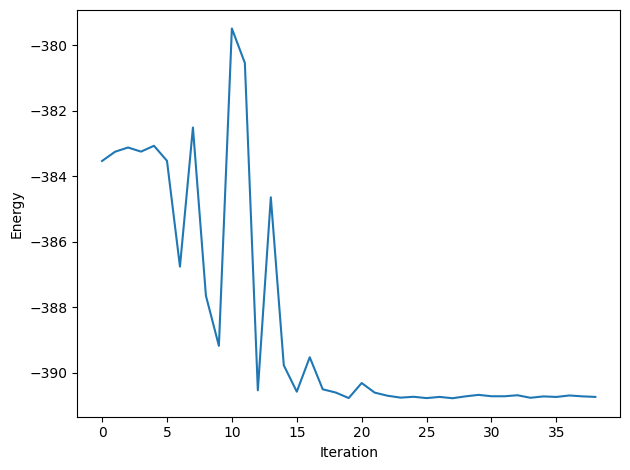

In [6]:
plt.plot(energy_trace)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.tight_layout()
plt.show()

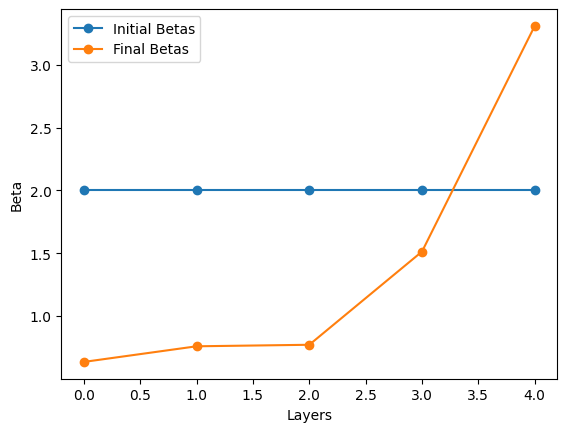

In [7]:
plt.plot(init_betas, marker="o", label="Initial Betas")
plt.plot(res.x, marker="o", label="Final Betas")
plt.xlabel("Layers")
plt.ylabel("Beta")
plt.legend()
plt.show()